<a href="https://colab.research.google.com/github/boyuan1004/CNN/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! pip install -q kaggle

from google.colab import files
files.upload()
#! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [12]:
! kaggle datasets download jessicali9530/caltech256

100% 2.11G/2.12G [00:17<00:00, 178MB/s]
100% 2.12G/2.12G [00:17<00:00, 133MB/s]


In [13]:
! mkdir caltech256
!unzip caltech256.zip -d caltech256

串流輸出內容已截斷至最後 5000 行。
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0077.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0078.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0079.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0080.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0081.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0082.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0083.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0084.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0085.jpg  
  inflating: caltech256/256_objectcategories/256_ObjectCategories/228.triceratops/228_0086.jpg  
  inflati

In [14]:
! kaggle competitions download -c nycu-facial-expression-recognition

! mkdir Face-expression

! unzip nycu-facial-expression-recognition.zip -d Face-expression

串流輸出內容已截斷至最後 5000 行。
  inflating: Face-expression/train/train/sad/Training_65242339.jpg  
  inflating: Face-expression/train/train/sad/Training_65267116.jpg  
  inflating: Face-expression/train/train/sad/Training_65275626.jpg  
  inflating: Face-expression/train/train/sad/Training_6529266.jpg  
  inflating: Face-expression/train/train/sad/Training_65329617.jpg  
  inflating: Face-expression/train/train/sad/Training_65338712.jpg  
  inflating: Face-expression/train/train/sad/Training_65338797.jpg  
  inflating: Face-expression/train/train/sad/Training_65387162.jpg  
  inflating: Face-expression/train/train/sad/Training_65404494.jpg  
  inflating: Face-expression/train/train/sad/Training_65426218.jpg  
  inflating: Face-expression/train/train/sad/Training_65430136.jpg  
  inflating: Face-expression/train/train/sad/Training_65437377.jpg  
  inflating: Face-expression/train/train/sad/Training_6545735.jpg  
  inflating: Face-expression/train/train/sad/Training_65463385.jpg  
  inflating: Fa

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim



In [22]:
from pathlib import Path
data_path = Path("./Face-expression")
image_path = data_path / "train"
image_path_test = data_path / "test"
data_path_c = Path("./caltech256")
image_path_c = data_path_c / "256_ObjectCategories"

In [16]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [23]:
#walk_through_dir(image_path)
walk_through_dir(image_path_c)

There are 257 directories and 0 images in 'caltech256/256_ObjectCategories'.
There are 0 directories and 94 images in 'caltech256/256_ObjectCategories/220.toaster'.
There are 0 directories and 83 images in 'caltech256/256_ObjectCategories/062.eiffel-tower'.
There are 0 directories and 95 images in 'caltech256/256_ObjectCategories/241.waterfall'.
There are 0 directories and 90 images in 'caltech256/256_ObjectCategories/243.welding-mask'.
There are 0 directories and 99 images in 'caltech256/256_ObjectCategories/172.revolver-101'.
There are 0 directories and 81 images in 'caltech256/256_ObjectCategories/201.starfish-101'.
There are 0 directories and 103 images in 'caltech256/256_ObjectCategories/185.skateboard'.
There are 0 directories and 95 images in 'caltech256/256_ObjectCategories/228.triceratops'.
There are 0 directories and 110 images in 'caltech256/256_ObjectCategories/038.chimp'.
There are 0 directories and 138 images in 'caltech256/256_ObjectCategories/101.head-phones'.
There are

In [29]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path_test / "test"
train_dir, test_dir

(PosixPath('Face-expression/train/train'),
 PosixPath('Face-expression/test/test'))

In [187]:
from torch.utils.data.dataset import random_split
from torchvision import datasets
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize([64,64])])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(root = image_path_c, transform = train_transform)
print(train_dataset.classes)
#test_data = datasets.ImageFolder(root = test_dir, transform = test_transform)
#train_dataset = torchvision.datasets.MNIST("./", train=True, download=True, transform=train_transform)
#test_dataset = torchvision.datasets.MNIST("./", train=False, download=True, transform=test_transform)

train_size=int(0.8*len(train_dataset))
val_size= int(0.1 *len(train_dataset))
test_size=len(train_dataset) - train_size - val_size
train_data, val_data,test_data = torch.utils.data.random_split(train_dataset, [train_size,val_size,test_size])
#m = len(train_data)
#train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '057.dolphin-101', '058.doorknob', '059.drinking-straw', '060.du

In [186]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.3761, 0.3532, 0.3545,  ..., 0.7668, 0.5974, 0.6641],
         [0.3319, 0.3180, 0.2774,  ..., 0.9289, 0.4788, 0.2636],
         [0.3523, 0.3312, 0.3401,  ..., 0.2256, 0.1399, 0.1714],
         ...,
         [0.5558, 0.6198, 0.6336,  ..., 0.1746, 0.1628, 0.1607],
         [0.6514, 0.7048, 0.1698,  ..., 0.1624, 0.1519, 0.1479],
         [0.5088, 0.2030, 0.2056,  ..., 0.1768, 0.1884, 0.1907]],

        [[0.5240, 0.5225, 0.5506,  ..., 0.8942, 0.7310, 0.7491],
         [0.4799, 0.4872, 0.4734,  ..., 0.9556, 0.4950, 0.2799],
         [0.4967, 0.5466, 0.5275,  ..., 0.3333, 0.1945, 0.2168],
         ...,
         [0.7313, 0.8360, 0.8442,  ..., 0.2178, 0.2114, 0.2063],
         [0.8153, 0.8467, 0.2489,  ..., 0.2056, 0.2006, 0.1934],
         [0.5712, 0.2582, 0.2488,  ..., 0.2233, 0.2262, 0.2039]],

        [[0.9197, 0.9410, 0.9847,  ..., 0.9939, 0.8626, 0.8722],
         [0.8756, 0.9057, 0.9129,  ..., 0.9916, 0.5557, 0.3210],
         [0.9095, 0.9643, 0.9731,  ..., 0.45

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AttributeError: ignored

In [182]:
img, label = next(iter(train_loader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print("valid part ---------")
img_vd, label_vd = next(iter(val_loader))
print(f"Image shape: {img_vd.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_vd.shape}")
img_test, label_test = next(iter(test_loader))
print(f"Image shape: {img_test.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_test.shape}")
print()

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Image shape: torch.Size([256, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([256])
valid part ---------
Image shape: torch.Size([256, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([256])


ValueError: ignored

#define encoder and decoder

**encoder class**

In [171]:
class Encoder(nn.Module):
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()

    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,stride=2,padding=1),
        nn.ReLU(True),
        nn.Conv2d(64,128,kernel_size=3, stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,224,kernel_size=3, stride=2,padding=1),
        nn.ReLU(True)
    )

    self.flatten = nn.Flatten(start_dim=1)

    self.encoder_linear = nn.Sequential(
        nn.Linear(14336, 128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
    )

  def forward(self,x):
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_linear(x)

    return x

encoderm = Encoder(4,128)
encoderm

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_linear): Sequential(
    (0): Linear(in_features=14336, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

**decoder class**

In [172]:

class Decoder(nn.Module):
  def __init__(self,encoded_space_dim, fc2_input_dim):
    super().__init__()
    self.decoder_lin = nn.Sequential(
        nn.Linear(encoded_space_dim, 128),
        nn.ReLU(True),
        nn.Linear(128,8*8*128),
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128,8,8))

    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64,3,kernel_size=3,stride=2,padding=1,output_padding=1)
    )

  def forward(self,x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)

    return x


decoderm = Decoder(4,128)
decoderm

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=8192, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 8, 8))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self,encoded_space_dim, fc2_input_dim):
    super(self).__init__()
    #encoder
    self.encoder = Encoder(encoded_space_dim, fc2_input_dim)
    #decoder
    self.decoder = Decoder(encoded_space_dim, fc2_input_dim)

  def forwaard(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return encoded, decoded

#lossfunction, optimizer

In [173]:
loss_fn = torch.nn.MSELoss()

lr = 0.001
torch.manual_seed(0)
#initialize the network
d=4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimizer = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimizer,lr=lr,weight_decay=1e-05)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoder.to(device)
decoder.to(device)


Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=8192, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 8, 8))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

#add noise to image

In [174]:
def add_noise(inputs, noise_factor=0.3):
  noisy = inputs + torch.rand_like(inputs) * noise_factor
  noisy = torch.clip(noisy,0.,1.)

  return noisy

#training and evaluation

In [175]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

#test

In [176]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):

  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    conc_out=[]
    conc_label=[]
    for image_batch, _ in dataloader:
      image_noisy = add_noise(image_batch, noise_factor)
      image_noisy = image_noisy.to(device)
      #encode data
      encoded_data = encoder(image_noisy)
      #decode data
      decoded_data = decoder(encoded_data)
      # Append the network output and the original image to the lists
      conc_out.append(decoded_data.cpu())
      conc_label.append(image_batch.cpu())
    
    #create a single tensor with all the value in lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)
    #evalute global loss
    val_loss = loss_fn(conc_out, conc_label)
  return val_loss.data


**autoencoder learning to reconstruct the image**



In [190]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    #targets = test_data.numpy()
    #t_idx = {i:np.where(targets==i)[0][0] for i in range(10)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_data[i][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

#trianing cycle

In [191]:
noise_factor = 0.3
num_epochs =5
history_da={'train_loss':[], 'val_loss':[]}

for epoch in range(num_epochs):
  print('EPOCH %d/%d' % (epoch + 1, num_epochs))

  train_loss = train_epoch(
      encoder=encoder,
      decoder=decoder,
      device=device,
      dataloader=train_loader,
      loss_fn=loss_fn,
      optimizer=optim,noise_factor=noise_factor
  )

  val_loss = test_epoch(
      encoder=encoder,
      decoder=decoder,
      device=device,
      dataloader=val_loader,
      loss_fn=loss_fn,noise_factor=noise_factor
  )
  # Print Validationloss
  history_da['train_loss'].append(train_loss)
  history_da['val_loss'].append(val_loss)
  print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  #plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


EPOCH 1/5


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	 partial train loss (single batch): 0.044479
	 partial train loss (single batch): 0.046071
	 partial train loss (single batch): 0.043721
	 partial train loss (single batch): 0.046273
	 partial train loss (single batch): 0.044377
	 partial train loss (single batch): 0.047941
	 partial train loss (single batch): 0.047272
	 partial train loss (single batch): 0.045865
	 partial train loss (single batch): 0.043976
	 partial train loss (single batch): 0.046495
	 partial train loss (single batch): 0.043873
	 partial train loss (single batch): 0.047579
	 partial train loss (single batch): 0.043970
	 partial train loss (single batch): 0.044564
	 partial train loss (single batch): 0.048854
	 partial train loss (single batch): 0.045724
	 partial train loss (single batch): 0.044303
	 partial train loss (single batch): 0.047030
	 partial train loss (single batch): 0.047653
	 partial train loss (single batch): 0.046954
	 partial train loss (single batch): 0.046781
	 partial train loss (single batch

In [ ]:
plt.plot(train_loss)
torch.save(model_ae, 'mode_AutoEncoder_MNIST.pth')


In [ ]:
plt.plpot(val_loss)

tensor([-5.2390, -3.0663, -0.5691, -0.8202])
tensor([3.2566, 4.5857, 2.6256, 3.7719])


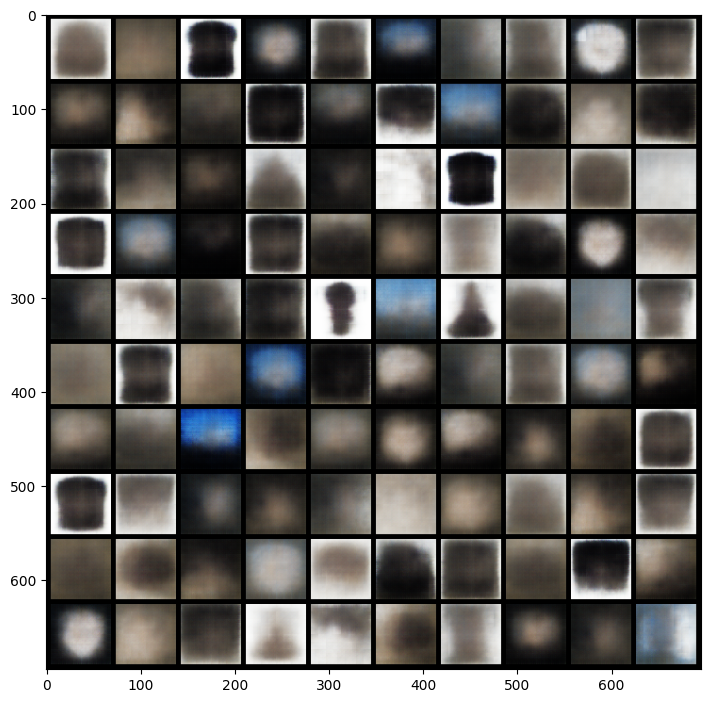

In [192]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()